In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets import *
from SR_UNet_simple import *

In [2]:
urma_sp_rest = xr.open_dataset("/scratch/RTMA/alex.schein/URMA_train_test/train/urma_20210101_t00z.nc", decode_timedelta=True)
urma_orig = xr.open_dataset("/scratch/RTMA/alex.schein/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp", engine="cfgrib", decode_timedelta=True)

skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(2.0)) new_value=Variable(dimensions=(), data=np.float64(10.0))
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key pre

In [3]:
IDX_MIN_LON = 595+1 #NOTE: different from URMA grid! 
IDX_MIN_LAT = 645

IMG_SIZE_LON = 180
IMG_SIZE_LAT = 180

# t2m_subset.to_netcdf("/scratch/RTMA/alex.schein/test_regridded.nc", encoding={"t2m":{"zlib":True, "complevel":9}})

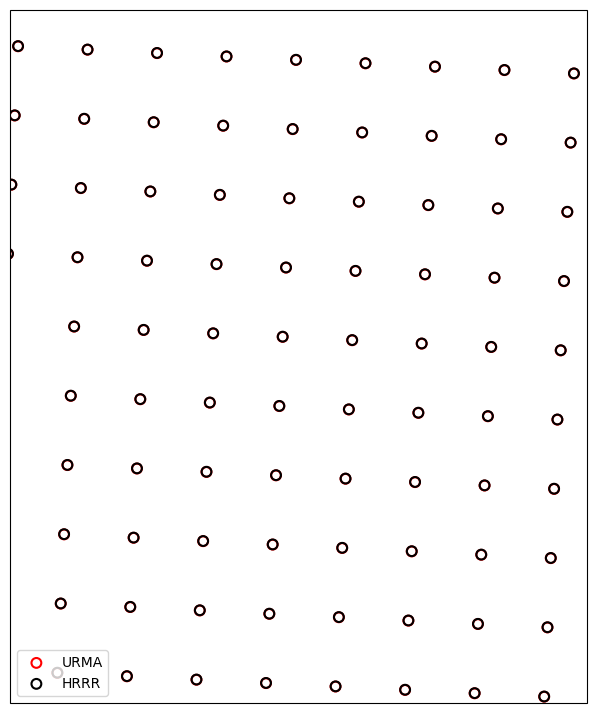

In [4]:
RADIUS = 6371950


hrrr_orig = xr.open_dataset(f"/scratch/RTMA/alex.schein/test_hrrr_newgrid_{RADIUS}.grib2", engine='cfgrib', decode_timedelta=True)
hrrr_sp_rest = hrrr_orig.isel(y=slice(IDX_MIN_LAT, IDX_MIN_LAT+IMG_SIZE_LAT),
                        x=slice(IDX_MIN_LON, IDX_MIN_LON+IMG_SIZE_LON))


projection = ccrs.LambertConformal(central_longitude = 265-360,
                                    central_latitude = 38.5,
                                    standard_parallels = (38.5,38.5),
                                    cutoff = 0)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(1,1,1, projection=projection)

#ax1.set_extent([230-360, 300-360, 19, 50])
ax1.set_extent([251-360, 251.2-360, 39, 39.2])
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax1.add_feature(cfeature.STATES.with_scale('50m'))
mks = MarkerStyle('o', fillstyle="none")
ax1.scatter(urma_sp_rest.longitude.data, urma_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='r', marker=mks, label='URMA')
ax1.scatter(hrrr_sp_rest.longitude.data, hrrr_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='k', marker =mks, label='HRRR')
plt.legend(loc='lower left')


In [7]:
difference_longitude = np.abs((hrrr_sp_rest.longitude - urma_sp_rest.longitude).data)
difference_latitude = np.abs((hrrr_sp_rest.latitude - urma_sp_rest.latitude).data)
difference_sqrt = np.sqrt(np.square(difference_latitude)+np.square(difference_longitude))
# np.unravel_index(difference_sqrt.argmin(), difference_sqrt.shape)
np.max(difference_latitude)

np.float64(6.102401091112597e-05)